In [6]:
'''
Description: IVRP State
Author: Group 5
Date: 2022-03-15
LastEditors: Ian Chong, Sean Goh
LastEditTime: 2022-03-17
'''

import copy
import numpy as np
import random
import os
import math
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from pathlib import Path

from typing import List

import sys


sys.path.append('./ALNS')
from alns import ALNS, State

### Parser to parse instance xml file ###
# You should not change this class!

import argparse
import numpy as np
import numpy.random as rnd
import networkx as nx
import matplotlib.pyplot as plt
import os

from pathlib import Path
sys.path.append(os.path.join('.','ALNS'))
import sys
import alns
from alns import ALNS, State
from alns.criteria import HillClimbing, SimulatedAnnealing, RecordToRecordTravel

class Parser(object):
    
    def __init__(self, dat_file):
        '''initialize the parser
        Args:
            dat_file::str
                the path to the .dat file
        '''
        self.name = os.path.splitext(dat_file)[0]
        
        self.datContent = [i.strip().split() for i in open(dat_file).readlines()]
        
        self.nNodes = int(self.datContent[0][0])
        self.nPeriods = int(self.datContent[0][1])
        self.customers=[]
        self.vehicles=[]
        self.depot=None
        self.set_depot()
        self.set_customers()        
        self.set_vehicles()
    
    def set_depot(self):
        # Initialize depot
        self.depot = Depot(int(self.datContent[1][0]), 0, float(self.datContent[1][1]), float(self.datContent[1][2]), 
                           int(self.datContent[1][3]), float(self.datContent[1][5]), int(self.datContent[1][4]))
    
    def set_customers(self):
        # Initialize customers    
        for i in range(len(self.datContent)):
            if i > 1:                
                self.customers.append(Customer(int(self.datContent[i][0]), 1, float(self.datContent[i][1]), float(self.datContent[i][2]), 
                                               int(self.datContent[i][3]), float(self.datContent[i][7]), int(self.datContent[i][6]),
                                               int(self.datContent[i][4]), int(self.datContent[i][5])))

    def set_vehicles(self):
        # Initialize Vehicle
        for i in range(int(self.datContent[0][3])):
            self.vehicles.append(Vehicle(i, self.depot, self.depot, int(self.datContent[0][2])))
        

### Node class ###
# You should not change this class!


class Node(object):

    def __init__(self, id:int, type:int, x:float, y:float, i:float, h:float, r:float):
        '''Initialize a node
        Args:
            id::int
                id of the node
            type::int
                0 for depot, 1 for customer
            x::float
                x coordinate of the node
            y::float
                y coordinate of the node
            i::float
                starting inventory level
            h::float
                inventory cost
            r::float
                Daily production/(consumption)
        '''
        self.id = id
        self.type = type
        self.x = x
        self.y = y
        self.i = i
        self.h = h
        self.r = r

    def get_nearest_node(self, nodes):
        '''Find the nearest node in the list of nodes
        Args:
            nodes::[Node]
                a list of nodes
        Returns:
            node::Node
                the nearest node found
        '''
        dis = [cdist([[self.x, self.y]], [[node.x, node.y]], 'euclidean')
               for node in nodes]
        idx = np.argmin(dis)
        return nodes[idx]
    
    def get_nearest_node_index(self, nodes):
        '''Find the nearest node in the list of nodes
        Args:
            nodes::[Node]
                a list of nodes
        Returns:
            node::Node
                the nearest node index found
        '''
        dis = [cdist([[self.x, self.y]], [[node.x, node.y]], 'euclidean') for node in nodes]
        idx = np.argmin(dis)
        return idx,nodes[idx]

    def __eq__(self, other):
        if isinstance(other, Node):
            return self.id == other.id and self.type == other.type and self.x == other.x and self.y == other.y
        return False

    def __str__(self):
        return 'Node id: {}, type: {}, x: {}, y: {}'.format(self.id, self.type, self.x, self.y)

### Depot class ###

class Depot(Node):

    def __init__(self, id:int, type:int, x:float, y:float, i:int, h:float, r:int):
        '''Initialize a depot
        Args:
            id::int
                id of the node
            type::int
                0 for depot, 1 for customer
            x::float
                x coordinate of the node
            y::float
                y coordinate of the node
            i::int
                starting inventory level
            h::float
                inventory cost
            r::int
                Daily production/(cost)
        '''
        super(Depot, self).__init__(id, type, x, y, i, h, r)
        
        # Initialize current inventory level
        self.current_inventory=i
        self.starting_inventories=[i]
        
        # Keep track of inventory costs
        self.inventory_cost=0
        self.inventory_costs=[]
    
    def __str__(self):
        return 'Node id: {}, type: {}, x: {}, y: {}, starting_inventory: {}, inventory_cost: {}, daily_production: {}'.format(self.id, self.type, self.x, self.y, self.i, self.h, self.r)
    
    def load(self,vehicle,load_policy:str='max',exact_load:float=None):
        '''Load a vehicle
        Args:
            vehicle::Vehicle
                Vehicle to load inventory
            load_policy::str ('max','exact','none')
                Determines how much to load
            exact_load::float
                If load_policy is 'exact', load the vechicle with this amount.            
        '''
        
        if load_policy=='max':
            inventory_loaded=min(self.current_inventory,vehicle.Q)
        elif load_policy=='exact':
            inventory_loaded=exact_load
        elif load_policy=='none':
            inventory_loaded=None
        
        vehicle.current_inventory+=inventory_loaded
        self.current_inventory-=inventory_loaded
        
    
    def accrue_cost(self):
        ''' Calculate cost for the period
        '''
        periodcost=self.current_inventory*self.h
        self.inventory_cost+=periodcost
        self.inventory_costs.append(periodcost)
    
    def produce(self):
        ''' Produce inventory for the period
        '''
        self.current_inventory+=self.r
        self.starting_inventories.append(self.current_inventory)
    def end_period(self):
        self.accrue_cost()
        self.produce()
        
        
### Customer class ###
# You should not change this class!


class Customer(Node):

    def __init__(self, id:int, type:int, x:float, y:float, i:int, h:float, r:int, u:int, l:int):
        '''Initialize a customer
        Args:
            id::int
                id of the node
            type::int
                0 for depot, 1 for customer
            x::float
                x coordinate of the node
            y::float
                y coordinate of the node
            i::int
                Starting inventory level
            h::float
                Inventory cost
            r::int
                Daily production/(cost)
            u::int
                Maximum inventory level
            l::int
                Minimum inventory level
        '''
        super(Customer, self).__init__(id, type, x, y, i, h, r)        
        self.u=u
        self.l=l
        
        # Inventory cost used in calculating objective function
        self.inventory_cost=0
        self.inventory_costs=[]
        self.current_inventory=self.i
        self.starting_inventories=[]
        self.starting_inventories.append(i)
        self.inventories_recieved=[]

    def __str__(self):
        return 'Node id: {}, type: {}, x: {}, y: {}, starting_inventory: {}, inventory_cost: {}, daily_production?: {} , min_inv: {} , max_inventory {} '.format(self.id, self.type, self.x, self.y, self.i, self.h,self.r, self.l,self.u)
    
    def accrue_cost(self):
        cost=self.current_inventory*self.h
        self.inventory_cost+=cost
        self.inventory_costs.append(cost)
        
    def consume(self):
        self.current_inventory-=self.r
        self.starting_inventories.append(self.current_inventory)
        
        
    def end_period(self):
        self.consume()
        self.accrue_cost()

### Vehicle class ###
# Vehicle class. You could add your own helper functions freely to the class, and not required to use the functions defined
# But please keep the rest untouched!


class Vehicle(object):

    def __init__(self, id:int, start_node:Node, end_node:Node, Q:float):
        ''' Initialize the vehicle
        Args:
            id::int
                id of the vehicle
            start_node::Node
                starting node of the vehicle
            end_node::Node
                ending node of the vehicle
            Q::float
                Vehicle capacity            
        '''
        self.id = id
        self.start_node = start_node
        self.end_node = end_node        
        self.Q = Q
        
        # To keep track of current node
        self.current_node= start_node

        # To keep track of inventory
        self.current_inventory=0
        
        # travel time of the vehicle
        self.travel_cost = 0
        
        # all the nodes including depot, customers, or charging stations (if any) visited by the vehicle
        self.node_visited = [self.start_node]  # start from depot

    def check_return(self):
        ''' Check whether the vehicle's return to the depot
        Return True if returned, False otherwise
        '''
        if len(self.node_visited) > 1:
            return self.node_visited[-1] == self.end_node
    
    def move(self,node_start:Node,node_end:Node):
        ''' Move the vehicle to next node, and deliver if customer
        Args:            
            node_start::Node
                Node to move from
            node_end::Node
                Node to move to
            
        '''
        
        self.travel_cost+=cdist([(node_start.x,node_start.y)],[(node_end.x,node_end.y)])
        self.current_node=node_end
        self.node_visited.append(node_end)
            
    def unload(self,node:Customer,unload_policy:str,exact_unload:float=None):        
        '''Unloads inventory from vehicle to node
        Args:
            node::Customer
                The node to unload at
            unload_policy::str ('max','exact')
                Determines how to unload inventory.
            exact_unload::float
                Inventory to unload under 'exact' policy
        '''
        if unload_policy=='max':
            inventory_unloaded = min(node.u - node.current_inventory,self.current_inventory)
                        
        elif unload_policy=='exact':
            inventory_unloaded=exact_unload
                            
        elif unload_policy=='none':
            inventory_unloaded=0                
        
        node.current_inventory+=inventory_unloaded
        self.current_inventory-=inventory_unloaded
        
    def __str__(self):
        return 'Vehicle id: {}, vehicle_capacity: {}'\
            .format(self.id, self.Q)

### EVRP state class ###
# EVRP state class. You could and should add your own helper functions to the class
# But please keep the rest untouched!


class IVRP(State):

    def __init__(self, name, depot: Depot, customers: List[Customer], vehicles: List[Vehicle], nPeriods:int, destruction: float = 0.25):
        '''Initialize the EVRP state
        Args:
            name::str
                name of the instance
            depot::Depot
                depot of the instance
            customers::[Customer]
                customers of the instance            
            vehicles::[Vehicle]   
                Vehicles of the instance
            nPeriods::int
                Number of periods to simulate
            destruction::Float
                Degree of destruction to be passed onto destroy operators where appropriate
        '''
        self.name = name
        self.depot = depot
        self.customers = customers        
        # record the vehicle used
        self.vehicles = vehicles
        # record numer of periods
        self.nPeriods = nPeriods
        # record the visited customers, eg. [Customer1, Customer2]
        self.customer_visited = []
        # record the unvisited customers, eg. [Customer9, Customer10]
        self.customer_unvisited = []
        # the route visited by each vehicle, eg. [vehicle1.node_visited, vehicle2.node_visited, ..., vehicleN.node_visited]
        self.route = []
        # Degree of destruction for destroy operators where appropriate
        self.destruction = destruction
        self.kmlabels=[] #shape of num_customers,num_ks
        self.num_k=0
        self.k_values=[]
        self.max_period_restock=vehicles[-1].Q*len(vehicles)
        self.tsp_route=[]
        self.tsp_route_cid=[]
        self.customer_latestrestock=[int(customer.i/customer.r) for customer in self.customers]
        self.dq=[] #dq=delivery quantities
        self.ei=[] #ei=ending inventories
        self.ei_depot=[0]
        self.euc2d=[]
        self.solutionspace=[[] for periods in range(self.nPeriods+1)]

    def random_initialize(self, seed=None):
        ''' Randomly initialize the state with split_route() (your construction heuristic)
        Args:
            seed::int
                random seed
        Returns:
            objective::float
                objective value of the state
        '''
        if seed is not None:
            random.seed(606)
        random_tour = copy.deepcopy(self.customers)

        random.shuffle(random_tour)
        self.split_route(random_tour)
        return self.objective()

    def copy(self):
        return copy.deepcopy(self)

    def split_route(self, tour):
        '''Generate the route given a tour visiting all the customers
        Args:
            tour::[Customer]
                a tour (list of Nodes) visiting all the customers        
        # You should update the following variables for the EVRP
        EVRP.vehicles
        EVRP.travel_time
        EVRP.customer_visited
        EVRP.customer_unvisited
        EVRP.route
        # You should update the following variables for each vehicle used
        Vehicle.travel_cost
        Vehicle.node_visited
        
        '''
        # You should implement your own method to construct the route of EVRP from any tour visiting all the customers
    
    def advance_time(self):        
        # Consume and then accrue costs
        for customer in self.customers:
            customer.consume()
            customer.accrue_cost()
        # Produce inventory at depot
        self.depot.produce()
        
    def initialize_tsp_nn(self):
        currentnode=self.depot
        tsp=[]
        tsp_id=[]
        customers=self.customers.copy()
        while len(customers)>0:
            idx,nextnode=currentnode.get_nearest_node_index(customers)
            tsp.append(nextnode)
            tsp_id.append(nextnode.id-1) #assumes the customers are always arranged by id and starts with id=1
            customers.pop(idx)
            currentnode=nextnode
        self.tsp_route=tsp
        self.tsp_route_cid=tsp_id
        
    def initialize_kmeans(self):
        number_veh = len(self.vehicles)
        avg_nodes_per_veh = sum([ customer.r for customer in self.customers]) / self.vehicles[0].Q
        long_term_cycle= avg_nodes_per_veh/number_veh
        #k_set=set([number_veh,int(avg_nodes_per_veh),int(math.ceil(avg_nodes_per_veh)),int(long_term_cycle),int(math.ceil(long_term_cycle))])
        k_set=set([number_veh,number_veh+1,int(avg_nodes_per_veh),int(math.ceil(avg_nodes_per_veh)),int(long_term_cycle),int(math.ceil(long_term_cycle)),len(self.customers)])
        k_candidates=[]
        for k in k_set:
            if k!=0 and k!=1:
                k_candidates.append(k)
        c_cord=np.array([[customer.x,customer.y] for customer in ivrp.customers])
        labels_c_k=np.array([[0 for k in k_candidates] for c in range(len(ivrp.customers))])

        for num_k,k in enumerate(k_candidates):
            kmeans=KMeans(n_clusters=k, random_state=7).fit(c_cord)
            labels=kmeans.labels_
            for num_c,label in enumerate(labels):
                labels_c_k[num_c,num_k]=label
                #find a more efficient representation of labels so that clusters can be pulled out in O(1)
                #a list with length of num k. len of labels[k] = n_clusters
        
        self.kmlabels=labels_c_k
        self.num_k=len(k_candidates)
        self.k_values=k_candidates
        return
    
    def initialize_euclidean(self):
        allnodes=[]
        allnodes.append(self.depot)
        allnodes.extend(self.customers)
        euc2d=[[0 for i in range(len(self.customers)+1)] for j in range(len(self.customers)+1) ]
        for i in range(len(allnodes)):
            for j in range(i,len(allnodes)):
                x1,y1=allnodes[i].x,allnodes[i].y
                x2,y2=allnodes[j].x,allnodes[j].y
                dist=((x1-x2)**2+(y1-y2)**2)**0.5
                euc2d[i][j]=dist
                euc2d[j][i]=dist
        self.euc2d=euc2d
                           
            
    
    def destroyrepair_clusters_feasible(self):
        #to figure out:
        #how much to stock
        #randomly pick a cluster to restock - 
        currentbuffer=self.customer_latestrestock.copy()
        currentstock=[customer.i for customer in self.customers]
        self.ei=[]
        self.ei.append(currentstock)
        cus_periodrestock=[[0 for p in range(self.nPeriods+1)] for c in self.customers] #customer by period matrixlist
        ei=[[0 for p in range(self.nPeriods+1)] for c in self.customers]
        excess_stock = self.depot.i
        self.ei_depot=[excess_stock]
        
        for period in range(1,self.nPeriods+1):
            urgent_customers=[]
            cus_min_restock=[]
            min_restock=0
            delivered=0
            #currentbuffer=[buffer-1 for buffer in currentbuffer]
            starting_inv=currentstock.copy()
            currentstock=[cus_stock-self.customers[num].r for num,cus_stock in enumerate(currentstock)]
            #print('currentstock')
            #print(currentstock)
            #print('currentbuffer')
            #print(currentbuffer)
            for num_cus,buffer in enumerate(currentbuffer):
                if buffer==0: #make solution feasible first if possible
                    urgent_customers.append(num_cus)
                    restockamount=self.customers[num_cus].r-currentstock[num_cus]
                    min_restock+=restockamount
                    #update current stock first
                    currentstock[num_cus]+=restockamount
                    cus_periodrestock[num_cus][period]+=restockamount
                    currentbuffer[num_cus]=1
                    cus_min_restock.append(restockamount)
                else:
                    cus_min_restock.append(0)
            #print("currentstock after adding min")
            #print(currentstock)
            delivered+=min_restock
            remaining_restock = max(min(self.max_period_restock-min_restock,excess_stock+self.depot.r-min_restock),0)
            #choose clusters to allocate - pick cluster that you HAVE to restock and try to load them up
            #Need to pick: 1) What k to use 2) which cluster to pick
            #How to load them up - just dump max in one of the clusters
            
            #randomize what k to use from a list of valid ks pre-computed
            choose_k_id=random.choice([i for i in range(self.num_k)])
            choose_k=ivrp.k_values[choose_k_id]
            #create probability distribution function
            cluster_dist={ label:1 for label in range(choose_k)}
            total_prob=choose_k
            for cus in urgent_customers:
                label=ivrp.kmlabels[cus,choose_k_id]
                cluster_dist[label]+=10
                total_prob+=10
            #normalize distribution
            cluster_dist_norm={ k:v/total_prob for (k,v) in cluster_dist.items()}
            
            
            while remaining_restock>0 and len(cluster_dist_norm) >0:
                choose_customer_cluster=random.choices(list(cluster_dist_norm.keys()),list(cluster_dist_norm.values()))[0]
                remaining_capacity=[customer.u-starting_inv[idx]-cus_min_restock[idx] for idx,customer in enumerate(self.customers)] #add in minrestock here
                customer_indexes=[]
                cluster_label=choose_customer_cluster
                for cus_num,label in enumerate(self.kmlabels[:,choose_k_id]):
                    if label==cluster_label:
                        customer_indexes.append(cus_num)
                cluster_remaining_capacity={idx:remaining_capacity[idx] for idx in customer_indexes}
                #print(cluster_remaining_capacity)
                maxfill=sum(cluster_remaining_capacity.values())
                if remaining_restock>=maxfill:
                    for k,v in cluster_remaining_capacity.items():
                        currentstock[k]+=v
                        delivered+=v
                        currentbuffer[k]=int(self.customers[k].u/self.customers[k].r)
                        cus_periodrestock[k][period]+=v
                    remaining_restock-=maxfill
                else:
                    while remaining_restock>0:
                        #choose customer k
                        #maybe should instead choose the lowest to fill
                        k=random.choice(list(cluster_remaining_capacity.keys()))
                        v=cluster_remaining_capacity[k]
                        add_stock=min(v,remaining_restock)
                        currentstock[k]+=add_stock
                        delivered+=add_stock
                        currentbuffer[k]=int(currentstock[k]/self.customers[k].r)
                        remaining_restock-=add_stock
                        cus_periodrestock[k][period]+=add_stock
                        cluster_remaining_capacity.pop(k)                                                
                
                #update probability distribution function dictionary
                total_prob-=cluster_dist_norm[choose_customer_cluster]
                cluster_dist_norm.pop(choose_customer_cluster)
                cluster_dist=cluster_dist_norm
                #renormalize probabilities
                if len(cluster_dist)>0:
                    cluster_dist_norm={ k:v/total_prob for (k,v) in cluster_dist.items()}
            
            #print('starting_stock: '+str(excess_stock))
            #print('delivered: '+str(delivered))
            #print('use: '+str(self.depot.r))
            excess_stock=excess_stock-delivered+self.depot.r
            #record ending inventory
            #endinginventory=[cus_stock-self.customers[num].r for num,cus_stock in enumerate(currentstock)]
            self.ei.append(currentstock)
            self.ei_depot.append(excess_stock)
            currentbuffer=[buffer-1 for buffer in currentbuffer] #shifted below
        self.dq=np.array(cus_periodrestock)
        
        return np.array(cus_periodrestock)
    
        def destroyrepair_clusters_risky(self):
            #to figure out:
            #how much to stock
            #randomly pick a cluster to restock - 
            currentbuffer=self.customer_latestrestock.copy()
            currentstock=[customer.i for customer in self.customers]
            self.ei=[]
            self.ei.append(currentstock)
            cus_periodrestock=[[0 for p in range(self.nPeriods+1)] for c in self.customers] #customer by period matrixlist
            ei=[[0 for p in range(self.nPeriods+1)] for c in self.customers]
            excess_stock = self.depot.i
            self.ei_depot=[excess_stock]

            for period in range(1,self.nPeriods+1):
                urgent_customers=[]
                cus_min_restock=[]
                min_restock=0
                delivered=0
                #currentbuffer=[buffer-1 for buffer in currentbuffer]
                starting_inv=currentstock.copy()
                currentstock=[cus_stock-self.customers[num].r for num,cus_stock in enumerate(currentstock)]
                #print('currentstock')
                #print(currentstock)
                #print('currentbuffer')
                #print(currentbuffer)
                for num_cus,buffer in enumerate(currentbuffer):
                    if buffer==0: #make solution feasible first if possible
                        urgent_customers.append(num_cus)
                        restockamount=self.customers[num_cus].r-currentstock[num_cus]
                        min_restock+=restockamount
                        #update current stock first
                        currentstock[num_cus]+=restockamount
                        cus_periodrestock[num_cus][period]+=restockamount
                        currentbuffer[num_cus]=1
                        cus_min_restock.append(restockamount)
                    else:
                        cus_min_restock.append(0)
                #print("currentstock after adding min")
                #print(currentstock)
                delivered+=min_restock
                remaining_restock = max(min(self.max_period_restock-min_restock,excess_stock+self.depot.r-min_restock),0)
                #choose clusters to allocate - pick cluster that you HAVE to restock and try to load them up
                #Need to pick: 1) What k to use 2) which cluster to pick
                #How to load them up - just dump max in one of the clusters

                #randomize what k to use from a list of valid ks pre-computed
                choose_k_id=random.choice([i for i in range(self.num_k)])
                choose_k=ivrp.k_values[choose_k_id]
                #create probability distribution function
                cluster_dist={ label:1 for label in range(choose_k)}
                total_prob=choose_k
                for cus in urgent_customers:
                    label=ivrp.kmlabels[cus,choose_k_id]
                    cluster_dist[label]+=10
                    total_prob+=10
                #normalize distribution
                cluster_dist_norm={ k:v/total_prob for (k,v) in cluster_dist.items()}


                while remaining_restock>0 and len(cluster_dist_norm) >0:
                    choose_customer_cluster=random.choices(list(cluster_dist_norm.keys()),list(cluster_dist_norm.values()))[0]
                    remaining_capacity=[customer.u-starting_inv[idx]-cus_min_restock[idx] for idx,customer in enumerate(self.customers)] #add in minrestock here
                    customer_indexes=[]
                    cluster_label=choose_customer_cluster
                    for cus_num,label in enumerate(self.kmlabels[:,choose_k_id]):
                        if label==cluster_label:
                            customer_indexes.append(cus_num)
                    cluster_remaining_capacity={idx:remaining_capacity[idx] for idx in customer_indexes}
                    #print(cluster_remaining_capacity)
                    maxfill=sum(cluster_remaining_capacity.values())
                    if remaining_restock>=maxfill:
                        for k,v in cluster_remaining_capacity.items():
                            currentstock[k]+=v
                            delivered+=v
                            currentbuffer[k]=int(self.customers[k].u/self.customers[k].r)
                            cus_periodrestock[k][period]+=v
                        remaining_restock-=maxfill
                    else:
                        while remaining_restock>0:
                            #choose customer k
                            #maybe should instead choose the lowest to fill
                            k=random.choice(list(cluster_remaining_capacity.keys()))
                            v=cluster_remaining_capacity[k]
                            add_stock=min(v,remaining_restock)
                            currentstock[k]+=add_stock
                            delivered+=add_stock
                            currentbuffer[k]=int(currentstock[k]/self.customers[k].r)
                            remaining_restock-=add_stock
                            cus_periodrestock[k][period]+=add_stock
                            cluster_remaining_capacity.pop(k)                                                

                    #update probability distribution function dictionary
                    total_prob-=cluster_dist_norm[choose_customer_cluster]
                    cluster_dist_norm.pop(choose_customer_cluster)
                    cluster_dist=cluster_dist_norm
                    #renormalize probabilities
                    if len(cluster_dist)>0:
                        cluster_dist_norm={ k:v/total_prob for (k,v) in cluster_dist.items()}

                #print('starting_stock: '+str(excess_stock))
                #print('delivered: '+str(delivered))
                #print('use: '+str(self.depot.r))
                excess_stock=excess_stock-delivered+self.depot.r
                #record ending inventory
                #endinginventory=[cus_stock-self.customers[num].r for num,cus_stock in enumerate(currentstock)]
                self.ei.append(currentstock)
                self.ei_depot.append(excess_stock)
                currentbuffer=[buffer-1 for buffer in currentbuffer] #shifted below
            self.dq=np.array(cus_periodrestock)

            return np.array(cus_periodrestock)
    
    def repair_dq(self):
        working_dq=self.dq.copy() #numpy
        working_ei=self.ei.copy() #list of list
        working_ei_depot=[self.depot.i]
        for period in range(1,self.nPeriods+1):
            allowance=working_dq[:,1]
            #choose k to use
            choose_k_id=random.choice([i for i in range(self.num_k)])
            choose_k=self.k_values[choose_k_id]
            #create probability distribution function
            cluster_dist={ label:1 for label in range(choose_k)}
            total_prob=choose_k
            for cus,delivery in enumerate(allowance):
                label=self.kmlabels[cus,choose_k_id]
                if delivery>0:
                    cluster_dist[label]+=10
                    total_prob+=10
            #normalize distribution
            cluster_dist_norm={ k:v/total_prob for (k,v) in cluster_dist.items()}
            total_delivered=0
            while len(cluster_dist_norm) >0:
                #pick a cluster
                cluster_label=random.choices(list(cluster_dist_norm.keys()),list(cluster_dist_norm.values()))[0]
        
                cluster_customers=[cusno for cusno,label in enumerate(self.kmlabels[:,choose_k_id]) if label==cluster_label ]
                while len(cluster_customers)>0:
                    #randomly choose customer
                    temp_idx=random.choice([i for i in range(len(cluster_customers))])
                    choose_customer=cluster_customers.pop(temp_idx)
                    end=working_ei[period][choose_customer]
                    buffer=int(end/self.customers[choose_customer].r)
                    logical_buffer=self.nPeriods-period
                    buffertouse=min(buffer,logical_buffer)
                    ei_touse=buffertouse*self.customers[choose_customer].r
                    starting_inventory=working_ei[period-1][choose_customer]
                    new_restock=ei_touse-starting_inventory+self.customers[choose_customer].r
            #update working
                    working_dq[choose_customer,period]=new_restock
                    working_ei[period][choose_customer]=ei_touse
                    total_delivered+=new_restock
        
        
                total_prob-=cluster_dist_norm[cluster_label]
                cluster_dist_norm.pop(cluster_label)
                cluster_dist=cluster_dist_norm
                #renormalize probabilities
                if len(cluster_dist)>0:
                    cluster_dist_norm={ k:v/total_prob for (k,v) in cluster_dist.items()}
                    
            depot_ending=working_ei_depot[-1]-total_delivered+self.depot.r
            #print("working ei depot: working:" +str(working_ei_depot[-1]))
            #print("total delivered: "+str(total_delivered))
            #print("depot ending: "+str(depot_ending))
                  
            working_ei_depot.append(depot_ending)
        self.dq=working_dq
        self.ei=working_ei
        self.ei_depot=working_ei_depot

    def try_swap_eliminate(self):
        for period in range(1,len(self.solutionspace)):
            routes=self.solutionspace[period]

            try:
                lastroute=routes[-1]
                secondlastroute=routes[-2]
                swap1=secondlastroute[-1]
                swap2=lastroute[0]
                if sum([qty for node,qty in lastroute])+swap1[1] <= self.vehicles[-1].Q and swap1[0]==swap2[0]:
                    self.solutionspace[period][-2].pop()
                    self.solutionspace[period][-1][0]=(swap1[0],swap1[1]+swap2[1])
            except:
                pass
                    
    
    def create_tour_from_tsp(self):
        self.solutionspace=[[] for periods in range(self.nPeriods+1)]
        solution_space=[]
        # solution space has a shape of time period by vehicles
        # i.e [[]]
        for period in range(1,self.nPeriods+1):
            deliveredqtys=0
            vehiclemaxcap=self.vehicles[0].Q
            vehiclecap=vehiclemaxcap
            remainingtotalcap=len(self.vehicles)*vehiclemaxcap
            vehicleroute=[]
            vehicle_idx=0
            
            for cidx in self.tsp_route_cid:
                qty=self.dq[cidx,period]
                if qty>0 and qty<=vehiclecap:
                    vehiclecap-=qty
                    
                    vehicleroute.append((cidx,qty))
                elif qty>vehiclecap:
                    while qty>0:
                        adjqty=min(qty,vehiclecap)
                        
                        #update solution space
                        qty-=adjqty
                    
                        #restart vehicle
                        if qty>0:                           
                            vehiclecap=vehiclemaxcap
                            vehicleroute.append((cidx,adjqty))
                            self.solutionspace[period].append(vehicleroute)
                            vehicleroute=[]
                            vehicle_idx+=1
                            vehiclecap=vehiclemaxcap
                        else:
                            vehiclecap=vehiclemaxcap-adjqty
                            vehicleroute.append((cidx,adjqty))
                    
                    #adjqty=qty-adjqty
            if len(vehicleroute)>0:
                self.solutionspace[period].append(vehicleroute)
                
        
    
                    
                    

        
        
    def objective(self):
        ''' Calculate the objective value of the state
        Return the total travel time and charging time of all vehicles used
        '''
        distancecost=0
        for num,period in enumerate(self.solutionspace):
            #print(period)
            for veh_num,veh in enumerate(self.solutionspace[num]):
                startidx=0
                for route_num,route in enumerate(veh):
                    nextcus,qty=route
                    nextidx=nextcus+1
                    distancecost+=self.euc2d[startidx][nextidx]
                    if route_num+1==len(veh):
                        startidx=nextidx
                        nextidx=0
                        distancecost+=self.euc2d[startidx][nextidx]
        inventorycost=0
        for i in range(1,len(self.ei)):
            endinginventories=self.ei[i]
            period_inventorycost=sum([ v*self.customers[k].h for k,v in enumerate(endinginventories)]) +self.ei_depot[i]
            inventorycost+=period_inventorycost
                
        
        return distancecost+inventorycost
    
# load data and random seed
parsed = Parser("/Users/enyong/OneDrive - Singapore Management University/MITB/MITB Modules/Semester 5/CS606 AI Planning and Decision Making G1/Group Project/IRP_small_instances/IRP_HighT6/S_abs1n5_2_H6.dat")
#parsed=Parser("IRP_HighT3\S_abs5n50_2_H3.dat")

ivrp = IVRP(parsed.name, parsed.depot, parsed.customers, parsed.vehicles, parsed.nPeriods)
ivrp.initialize_kmeans()
ivrp.initialize_euclidean()
ivrp.initialize_tsp_nn()

ivrp.destroyrepair_clusters_feasible()
ivrp.repair_dq()
ivrp.create_tour_from_tsp()
ivrp.try_swap_eliminate()
# print(ivrp.objective())
# print(ivrp.ei)
# print(ivrp.ei_depot)
# print(ivrp.solutionspace)
# print(ivrp.dq)

def clusterswap(current, random_state):
    destroyed = current.copy()
    destroyed.destroyrepair_clusters_feasible()
    destroyed.repair_dq()
    
    return destroyed

def clusterswap2(current, random_state):
    destroyed = current.copy()
    destroyed.destroyrepair_clusters_feasible()
    destroyed.repair_dq()
    
    return destroyed

def repair(destroyed, random_state):
    ''' repair operator sample (name of the function is free to change)
    Args:
        destroyed::EVRP
            an EVRP object after destroying
        random_state::nufmpy.random.RandomState
            a random state specified by the random seed
    Returns:
        repaired::EVRP
            the evrp object after repairing
    '''
    # You should code here

    destroyed.create_tour_from_tsp()
    destroyed.try_swap_eliminate()
    return destroyed

def random_twoswap(current, random_state):
    destroyed = current.copy()
    # You should code here
    tsp_route=destroyed.tsp_route_cid
    n=len(tsp_route)
    #choose 2 random number
    indexes=[i for i in range(n-1)]
    #print(tsp_route)
    swap1,swap2=random.sample(indexes, 2)
    tsp_route[swap1],tsp_route[swap2]=tsp_route[swap2],tsp_route[swap1]
    #repair route
    destroyed.create_tour_from_tsp()
    destroyed.try_swap_eliminate()
    return destroyed
import time
tick = time.time()

evrp=ivrp.copy()
random_state = rnd.RandomState(5)
alns = ALNS(random_state)
    # add destroy
    # You should add all your destroy and repair operators
alns.add_destroy_operator(clusterswap)
    # add repair
alns.add_repair_operator(repair)
alns.add_repair_operator(random_twoswap)

    # run ALNS
    # select cirterion
#criterion = SimulatedAnnealing(start_temperature=1000, end_temperature=1, step=1 - 1e-3, method="exponential")
criterion = HillClimbing()
    # assigning weights to methods
omegas = [5,2,1,0.5]
lambda_ = 0.8
result = alns.iterate(evrp, omegas, lambda_, criterion, iterations=1000, collect_stats=True)

    # result
solution = result.best_state
objective = solution.objective()
tock=time.time()
time_taken = tock - tick

endinginventories=np.array(ivrp.ei).T

newsolutionspace=copy.deepcopy(ivrp.solutionspace)

for t,timeperiod in enumerate(ivrp.solutionspace):
    for v,vehicles in enumerate(timeperiod):
        for r,solution in enumerate(vehicles):
            customeridx,dq= solution
            new_idx = customeridx+1
            newsolutionspace[t][v][r]=(new_idx,dq)
            
for t,timeperiod in enumerate(newsolutionspace):
    for vehicles in timeperiod:
        vehicles.append((0,0))
        vehicles.insert(0,(0,0))
        
endinginventories_temp = ivrp1.ei_depot + endinginventories
new_quantity_delivered = [[j for j in i] if len(i) == 2 else [[(0, 0), (0, 0)],[(0, 0), (0, 0)]] if len(i) == 0 else [j for j in i] + [[(0, 0), (0, 0)]] for i in newsolutionspace[1:]]
str_builder1 = []
str_builder1 = ['Instance: {}\nObjective: {}\nTime Taken: {}\n'.format(ivrp.name, objective, time_taken)]
str_builder1.append('Inventory Levels:-\n')
inven_level = []
for i in range(n_cust):
    inven_level_temp = []
    for j in range(t_period):
        inven_level_temp.append(endinginventories_temp[i][j])
    str_builder1.append('Node ' + str(i) + ': ' + ', '.join(str(k) for k in inven_level_temp))
    inven_level.append(inven_level_temp)
str_builder1.append('\n')

str_builder1.append('Consolidated Routes:-')
quantity_delivered = []
for t in range(t_period - 1):
    str_builder1.append('\nTime Period ' + str(t) + ":")
    for k in range(n_veh):
        str_builder1.append("Vehicle " + str(k) + ": " + ", ".join([str(i) for i in new_quantity_delivered[t][k]]))

TypeError: iterate() got multiple values for argument 'iterations'

In [7]:
### LIBRARY
import os
from ivrp import *
from docplex.mp.model import Model
import matplotlib.pyplot as plt

### LOAD DATA

path = "/Users/enyong/OneDrive - Singapore Management University/MITB/MITB Modules/Semester 5/CS606 AI Planning and Decision Making G1/Group Project/IRP_small_instances/IRP_HighT6/S_abs1n5_2_H6.dat"

Instance: S_abs1n5_2_H6.dat
Objective: 5973.339999999999
Time Taken: 4.116466999053955 - integer optimal, tolerance

Inventory Levels:-

Node 0: 875, 1213, 1197, 1029, 1114, 1049, 1387
Node 1: 130, 65, 125, 70, 130, 65, 0
Node 2: 182, 91, 0, 152, 61, 91, 0
Node 3: 75, 0, 26, 75, 0, 75, 0
Node 4: 86, 43, 0, 86, 43, 68, 25
Node 5: 64, 0, 64, 0, 64, 64, 0


Consolidated Routes:-

Time Period 1:
Vehicle 0: (0, 0), (0, 0)
Vehicle 1: (0, 0), (0, 0)

Time Period 2:
Vehicle 0: (0, 0), (3, 101), (0, 0)
Vehicle 1: (0, 0), (5, 128), (1, 125), (0, 0)

Time Period 3:
Vehicle 0: (0, 0), (1, 10), (2, 243), (0, 0)
Vehicle 1: (0, 0), (3, 124), (4, 129), (0, 0)

Time Period 4:
Vehicle 0: (0, 0), (1, 125), (5, 128), (0, 0)
Vehicle 1: (0, 0), (0, 0)

Time Period 5:
Vehicle 0: (0, 0), (5, 64), (2, 121), (4, 68), (0, 0)
Vehicle 1: (0, 0), (3, 150), (0, 0)

Time Period 6:
Vehicle 0: (0, 0), (0, 0)
Vehicle 1: (0, 0), (0, 0)


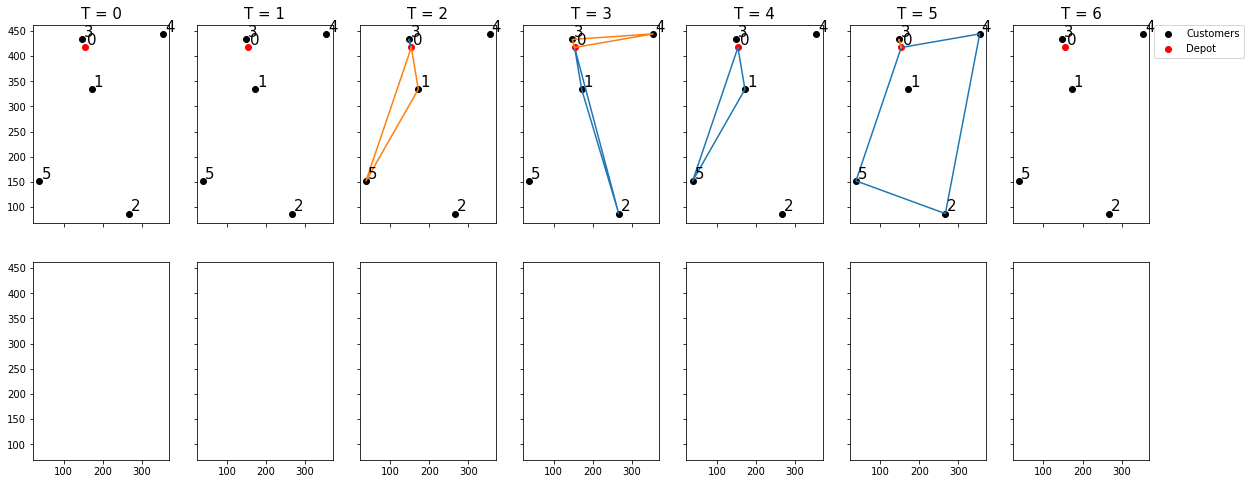

In [8]:
parsed = Parser(path)
ivrp = IVRP(parsed.name, parsed.depot, parsed.customers, parsed.vehicles, parsed.nPeriods)

### MODEL INITIALIZATION 

m = Model('ivrp')

### DECISION VARIABLES FORUMATION

#no. of customers
n_cust = len(ivrp.customers)
#no. of nodes (customers+depot)
n_node = n_cust + 1
#no. of vehicles
n_veh = len(ivrp.vehicles)
#no. of periods (incl. t=0 for initial state)
t_period = ivrp.nPeriods + 1

# list of node-period pair (i, t) excl. t=0 initial period, incl. depot
I = []
for t in range(t_period):
    for i in range(n_node):
        I.append((i, t))

# List of customer pairs (i,j), no depot
A = []
for i in range(n_cust):
    for j in range(n_cust):
        if i != j:
            A.append((ivrp.customers[i].id, ivrp.customers[j].id))

# list of cust-vehicle-period (i,k,t) excl depot excl t=0 initial period 
Q = []
for t in range(1, t_period):
    for k in range(n_veh):
        for i in range(1, n_node):
            Q.append((i, k, t))

# list of customer-customer-vehicle-period (i,j,k,t) excl. t=0 initial period, incl depot
X = []
for t in range(1, t_period): 
    for k in range(n_veh):
        for i in range(n_node):
            for j in range(n_node):
                if j != i:
                    X.append((i, j, k, t))

# i(i,t) = inventory level of customer i in period t
# q(i,k,t) = qunatity delivered to customer i via vehicle k in period t
# y(i,k,t) = 1 if customer i is visited by vehicle k in period t
# w(i,k,t) = cumulative qty delivered by k up to and incl. cust i in t
# x(i,j,k,t) = 1 if customer j is visited after customer i via k in t
inv = m.continuous_var_dict(I, name = 'inv')
q = m.continuous_var_dict(Q, lb = 0, name = 'qty')
y = m.binary_var_dict(Q, name = 'y')
w = m.continuous_var_dict(Q, lb = 0, name = 'w')
x = m.binary_var_dict(X, name = 'x')


### PARAMETERS DEFINITION                    

# distance between customers 
c = {(i,j) : round(cdist([[ivrp.customers[int(i-1)].x, 
                     ivrp.customers[int(i-1)].y]], 
                   [[ivrp.customers[int(j-1)].x, 
                     ivrp.customers[int(j-1)].y]], 
                   'euclidean')[0][0]) for (i,j) in A}

# depot-customer pairs and their distances
for i in range(1,n_node):
    A.append((0,i))
    c[0,i] = round(cdist([[ivrp.depot.x, 
                   ivrp.depot.y]], 
                 [[ivrp.customers[int(i-1)].x, 
                   ivrp.customers[int(i-1)].y]], 
                 'euclidean')[0][0])
    c[i,0] = c[0,i]

# holding cost at depot and customers
h = {}
h[0] = ivrp.depot.h
for i in ivrp.customers:
    h[i.id] = i.h

# daily production at depot
r = ivrp.depot.r

# daily demand|consumption for each customer
d = {}
for i in ivrp.customers:
    d[i.id] = i.r

# min inventory level
l = {}
for i in ivrp.customers:
    l[i.id]=i.l

# max inventory level
u = {}
for i in ivrp.customers:
    u[i.id]=i.u

# initial inventory (at t=0) 
m.add_constraint(inv[(0,0)] == ivrp.depot.i)
for i in ivrp.customers:
    m.add_constraint(inv[(i.id, 0)] == i.i)

# vehicle capacity
cap = {}
for i in ivrp.vehicles:
    cap[i.id] = i.Q


### MODEL FORUMATION

### OBJECTIVE FUNTION

#(1) Objective function
m.minimize(m.sum((h[i] * inv[(i, t)])
                 for i in range(n_node) 
                 for t in range(1, t_period)) + \
           m.sum((c[(i, j)] * x[(i, j, k, t)])
                 for i in range(n_node)
                 for j in range(n_node) if j != i
                 for k in range(n_veh) 
                 for t in range(1, t_period)))

### CONSTRAINTS

#(2) Inv at Depot this period = last period's + production - delivered
m.add_constraints((inv[(0,t)] == inv[(0,t-1)] + r - 
                  (m.sum(q[(i,k,t)] 
                         for i in range(1,n_node)
                         for k in range(n_veh))))
                for t in range(1,t_period))

#(3) Inv at Depot >=0
m.add_constraints(inv[(0,t)] >= 0 for t in range(1,t_period))

#(4) Inv at Cust = last period's inv - consumed + delivered
m.add_constraints((inv[(i,t)] == inv[(i,t-1)] - d[i]
                  + m.sum(q[(i,k,t)] 
                         for k in range(n_veh)))
                 for i in range(1,n_node)
                 for t in range(1,t_period))

#(5) Inv at Cust >= lower bound
m.add_constraints((inv[(i,t)] >= l[i])
                 for i in range(1,n_node)
                 for t in range(1,t_period))

#(6) Inv at Cust <= upper bound
m.add_constraints((inv[i,t]<=u[i])
                 for i in range(1,n_node)
                 for t in range(1,t_period))

#(7) Qty delivered cannot exceed space in Cust warehouse (i.e. upper - existing inv)
m.add_constraints((m.sum(q[(i,k,t)] for k in range(n_veh)) <= u[i] - inv[(i,t-1)])
                 for i in range(1,n_node)
                 for t in range(1,t_period))

#(8) If x is 1, qty delivered<capacity, if x is 0, qty delivered=0. Capacity is the large-M
m.add_constraints((m.sum(q[(i,k,t)] for k in range(n_veh)) <= 
                  u[i] * m.sum((x[(i,j,k,t)] 
                        for j in range(n_node) if j != i
                        for k in range(n_veh))))
                  for i in range(1,n_node)
                  for t in range(1,t_period))

#(9) Qty to be delivered by each vehicle within vehicle's capacity
m.add_constraints((m.sum(q[(i,k,t)] for i in range(1,n_node)) <= 
                  cap[k])
                  for k in range(n_veh) 
                  for t in range(1,t_period))

#(10) qty delivered to each cust is below capacity if visited, and 0 if not visited. Capacity is the large-M
m.add_constraints((q[(i,k,t)]<=(y[(i,k,t)]*u[i]))
                  for i in range(1,n_node)
                  for k in range(n_veh)
                  for t in range(1,t_period))

#(11) for each visited cust, there must be a node before and after 
m.add_constraints((m.sum(x[(i,j,k,t)] for j in range(n_node) if i!=j) ==
                   m.sum(x[(j,i,k,t)] for j in range(n_node) if j!=i))
                  for i in range(1,n_node)
                  for k in range(n_veh)
                  for t in range(1,t_period))
m.add_constraints(((m.sum(x[(i,j,k,t)] for j in range(n_node) if i!=j) ==
                   m.sum(y[(i,k,t)]))
                  for i in range(1,n_node)
                  for k in range(n_veh)
                  for t in range(1,t_period)))
m.add_constraints(((m.sum(x[(j,i,k,t)] for j in range(n_node) if i!=j) ==
                   m.sum(y[(i,k,t)]))
                  for i in range(1,n_node)
                  for k in range(n_veh)
                  for t in range(1,t_period)))

#(12) at most one route from each node (more for Depot)
m.add_constraints((m.sum(x[(0,j,k,t)] for j in range(1, n_node)) <= 1)
                  for k in range(n_veh) 
                  for t in range(1,t_period))

#(13) at most one veh visited each cust 
m.add_constraints((m.sum(y[(i,k,t)] for k in range(n_veh)) <= 1)
                  for i in range(1,n_node) 
                  for t in range(1,t_period))

#(14) routing logic (subtour elimination)
m.add_constraints(((w[(i,k,t)] - w[(j,k,t)] + (cap[k])*(x[(i,j,k,t)]))
                  <= (cap[k]) - q[(j,k,t)])
                  for i in range(1,n_node) 
                  for j in range(1,n_node) if j!=i 
                  for k in range(n_veh) 
                  for t in range(1,t_period))

#(15) variable logic
m.add_constraints((q[(i,k,t)] <= w[(i,k,t)])
                  for i in range(1,n_node) 
                  for k in range(n_veh) 
                  for t in range(1,t_period))
m.add_constraints((w[(i,k,t)] <= cap[k])
                  for i in range(1,n_node) 
                  for k in range(n_veh) 
                  for t in range(1,t_period))
#m.add_constraints(q[(i,k,t)] <= cap[k]
#                  for i in range(1,n_node) 
#                  for k in range(n_veh) 
#                  for t in range(1,t_period))
#m.add_constraints(q[(i,k,t)] <= w[(i,k,t)] <= cap[k] 
#                  for i in range(1,n_node) 
#                  for k in range(n_veh) 
#                  for t in range(1,t_period))


#(16) & (17)
# covered in var definition

### SOLUTION

solution = m.solve(log_output = False)

str_builder = ['Instance: {}\nObjective: {}\nTime Taken: {} - {}\n'.format(ivrp.name, solution.get_objective_value(), solution.solve_details.time, solution.solve_details.status)]
str_builder.append('Inventory Levels:-\n')
inven_level = []
for i in range(n_node):
    inven_level_temp = []
    for j in range(t_period):
        inven_level_temp.append(round(inv[i, j].solution_value))
    str_builder.append('Node ' + str(i) + ': ' + ', '.join(str(k) for k in inven_level_temp))
    inven_level.append(inven_level_temp)
str_builder.append('\n')

str_builder.append('Consolidated Routes:-')
quantity_delivered = []
for t in range(1, t_period):
    str_builder.append('\nTime Period ' + str(t) + ":")
    quantity_delivered_temp = []
    for k in range(n_veh):
        vehicle_temp_str = []
        quantity_delivered_temp_temp = []
        vehicle_temp_str.append('Vehicle ' + str(k) + ': (0, 0)')
        quantity_delivered_temp_temp.append((0, 0))
        next_node = -1
        for i in range(1, n_node):
            if x[0, i, k, t].solution_value:
                next_node = i
        while next_node > 0:
            for j in range(n_node):
                if j != next_node:
                    if x[next_node, j, k, t].solution_value == 1:
                        if next_node != 0:
                            vehicle_temp_str.append("(" + str(next_node) + ", " + str(round(q[next_node, k, t].solution_value)) + ")")
                            quantity_delivered_temp_temp.append((next_node, round(q[next_node, k, t].solution_value)))
                        else:
                            vehicle_temp_str.append(str(j))
                            quantity_delivered_temp_temp.append((0, 0))
                        next_node = j
                        break
        str_builder.append(', '.join(vehicle_temp_str) + ', (0, 0)')
        quantity_delivered_temp.append(quantity_delivered_temp_temp + [(0, 0)])
    quantity_delivered.append(quantity_delivered_temp)

print('\n'.join(str_builder))

fig, ax = plt.subplots(2, t+1, figsize = (20,8), sharex = True, sharey = True)

for i in range(t+1):
    ax[0, i].scatter([j.x for j in ivrp.customers], [j.y for j in ivrp.customers], label = 'Customers', c = "black")
    ax[0, i].scatter(ivrp.depot.x, ivrp.depot.y, label = 'Depot', c = 'red')
    ax[0, i].text(ivrp.depot.x + 5, ivrp.depot.y + 5, ivrp.depot.id, size = 15)
    for k in range(n_cust):
        ax[0, i].text(ivrp.customers[k].x + 5, ivrp.customers[k].y + 5, ivrp.customers[k].id, size = 15)

cust_list_temp = [ivrp.depot]+ivrp.customers
for i in range(1, t+1):
    for k in range(n_veh):
        ax[0, i].plot([cust_list_temp[node[0]].x for node in quantity_delivered[i-1][k]],
                      [cust_list_temp[node[0]].y for node in quantity_delivered[i-1][k]])

for i in range(t+1):
    ax[0, i].set_title("T = " + str(i), size = 15)
ax[0, t].legend(bbox_to_anchor = (1.0, 1.025))
plt.show()

In [ ]:
print('\n'.join(str_builder1))

fig, ax = plt.subplots(2, t+1, figsize = (20,8), sharex = True, sharey = True)

for i in range(t+1):
    ax[1, i].scatter([j.x for j in ivrp.customers], [j.y for j in ivrp.customers], label = 'Customers', c = "black")
    ax[1, i].scatter(ivrp.depot.x, ivrp.depot.y, label = 'Depot', c = 'red')
    ax[1, i].text(ivrp.depot.x + 5, ivrp.depot.y + 5, ivrp.depot.id, size = 15)
    for k in range(n_cust):
        ax[0, i].text(ivrp.customers[k].x + 5, ivrp.customers[k].y + 5, ivrp.customers[k].id, size = 15)

cust_list_temp = [ivrp.depot]+ivrp.customers
for i in range(1, t+1):
    for k in range(n_veh):
        ax[1, i].plot([cust_list_temp[node[0]].x for node in quantity_delivered[i-1][k]],
                      [cust_list_temp[node[0]].y for node in quantity_delivered[i-1][k]])

for i in range(t+1):
    ax[1, i].set_title("T = " + str(i), size = 15)
ax[1, t].legend(bbox_to_anchor = (1.0, 1.025))
plt.show()

In [ ]:
print('\n'.join(str_builder1))